In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings
import numpy as np 
import pandas as pd

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [31]:
question= pd.read_csv("D:\Question tagging system\Dataset\Questions.csv", encoding="ISO-8859-1")
tags= pd.read_csv("D:\Question tagging system\Dataset\Tags.csv", encoding="ISO-8859-1")

In [33]:
question.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [35]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [37]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [39]:
print(question.shape, tags.shape)

(1264216, 7) (3750994, 2)


In [41]:
question.columns

Index(['Id', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Score', 'Title',
       'Body'],
      dtype='object')

dropping unneccessary coloumns from questions dataframe

In [44]:
question.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
question.head()

,Id,Score,Title,Body
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


 merge both dataframes. In order to do that, I'll have to group tags by the id of the post since a post can have multiple tags. I'll just use the groupeby function and then merge the dataframes on the id.

In [47]:
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [49]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [51]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})
grouped_tags_final.head()

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [53]:
df = question.merge(grouped_tags_final, on='Id')
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [55]:
new_df = df[df['Score']>5]
new_df.info

<bound method DataFrame.info of                Id  Score                                              Title  \
0              80     26  SQLStatement.execute() - multiple queries in o...   
1              90    144  Good branching and merging tutorials for Torto...   
2             120     21                                  ASP.NET Site Maps   
3             180     53                 Function for creating color wheels   
4             260     49  Adding scripting functionality to .NET applica...   
...           ...    ...                                                ...   
1262915  40111730      7           How to use a dict to subset a DataFrame?   
1263065  40115300      7  Is there a way to use itertools in python to c...   
1263399  40123880      8  How can I force file ordering in F# projects u...   
1263454  40125310      6  Why does my result data returned as void* gets...   
1264205  40143070      6       What exactly makes a type system consistent?   

                   

In [57]:
new_df.isna().sum()

Id       0
Score    0
Title    0
Body     0
Tags     0
dtype: int64

In [59]:
new_df.duplicated().sum()

0

In [61]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

In [63]:
new_df.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


**preprocessing on tags column

In [66]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [68]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]
len(all_tags)

224129

In [70]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

14883

take most 100 frequented tags

In [73]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]
tags_features

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml',
 'bash',
 'ajax',
 'delphi',
 'cocoa-touch',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'linq',
 'debugging',
 'generics',
 'perl',
 'entity-framework',
 'mongodb',
 'winforms',
 'cocoa',
 'security',
 'postgresql',
 'css3',
 'templates',
 'twitter-bootstrap',
 'shell',
 'list',
 'google-chrome',
 'vim',
 'oop',
 'image',
 'hibernate',
 'gcc',
 'asp.net-mvc-3',
 'facebook',
 'oracle',
 'rest',
 'maven',
 'http',
 'exception',
 'tsql',
 'ma

In [75]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

if tag is from the most frequented tags we take it else we remove it from the data frame and replace it by none

In [78]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)
new_df.shape

(72950, 3)

In [79]:
new_df.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,None
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"


dropping tags with none values

In [83]:
new_df.dropna(subset=['Tags'], inplace=True)
print(new_df.shape)
new_df.head()

(63167, 3)


,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"


preprocessing on body column


using beatuiful soap to convert html to text

In [87]:
new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 
new_df.head()

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...,[svn]
2,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...,"[sql, asp.net]"
3,Function for creating color wheels,This is something I've pseudo-solved many time...,[algorithm]
4,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,"[c#, .net]"
5,Should I use nested classes in this case?,I am working on a collection of classes used f...,"[c++, oop, class]"


In [88]:
token=ToktokTokenizer()

In [91]:
def remove_punctuation(text):
    words=token.tokenize(text)
    filtered=[]
    for w in words:
        if w not in tags_features:
            new_w=w.translate(str.maketrans('', '', string.punctuation))
            filtered.append(new_w)
        else:
            filtered.append(w)         
    s = " "
    s=s.join(filtered)
    return s
    
    

In [93]:
#to check if the function (remove punctuation) is working as we expeted
import string
text="text and word c# b. / "
words=token.tokenize(text)
filtered=[]
for w in words:
    if w not in tags_features:
        new_w=w.translate(str.maketrans('', '', string.punctuation))
        filtered.append(new_w)
    else:
        filtered.append(w)
print(filtered)            
s = " "
s=s.join(filtered)
s

['text', 'and', 'word', 'c#', 'b', '']


'text and word c# b '

cleaning text by:
* lowercase
* replacing some words
* Remove spaces at the beginning and at the end of the text

In [96]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [98]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [100]:
new_df['Body']= new_df['Body'].apply(lambda x: re.sub('<[^<]+?>','',x))
new_df.head()

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,are there any really good tutorials explaining...,[svn]
2,ASP.NET Site Maps,has anyone got experience creating sql-based a...,"[sql, asp.net]"
3,Function for creating color wheels,this is something i have pseudo-solved many ti...,[algorithm]
4,Adding scripting functionality to .NET applica...,i have a little game written in c#. it uses a ...,"[c#, .net]"
5,Should I use nested classes in this case?,i am working on a collection of classes used f...,"[c++, oop, class]"


In [102]:
new_df['Body'] = new_df['Body'].apply(lambda x: remove_punctuation(x))

In [103]:
new_df['Body'][2]

'has anyone got experience creating sqlbased asp.net sitemap providers  i have got the default xml file websitemap working properly with my menu and sitemappath controls  but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well '

* Lemmatizing words
* Removing stop words

In [105]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to C:\Users\Tejas
[nltk_data]    |     Susladkar\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to C:\Users\Tejas
[nltk_data]    |     Susladkar\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Tejas
[nltk_data]    |     Susladkar\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Tejas
[nltk_data]    |     Susladkar\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Tejas
[nlt

True

In [106]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [107]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [108]:


def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [115]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

aplying same preprocessing on title coloumn

In [118]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: remove_punctuation(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

In [120]:
new_df.head()

,Title,Body,Tags
1,good branch merge tutorials tortoisesvn,really good tutorials explain branch merge apa...,[svn]
2,asp.net site map,anyone get experience create sqlbased asp.net ...,"[sql, asp.net]"
3,function create color wheel,something pseudosolved many time never quite f...,[algorithm]
4,add script functionality .net applications,little game write c use database backend trade...,"[c#, .net]"
5,use nest class case,work collection class use video playback recor...,"[c++, oop, class]"


tf-idf for body and title

In [123]:
new_df['Title']= new_df['Title'].astype(str)
vectorizer = TfidfVectorizer()
X1 = vectorizer.fit_transform(new_df['Title'].str.lower())

In [124]:
new_df['Body']= new_df['Body'].astype(str)
vectorizer = TfidfVectorizer()
X2 = vectorizer.fit_transform(new_df['Body'].str.lower())

**Binarize the tags by applying MultiLabelBinarizer**

In [128]:
y = new_df['Tags']
multilabel_binarizer = MultiLabelBinarizer()
new_y = multilabel_binarizer.fit_transform(y)

In [130]:
new_y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [132]:
X=hstack([X1,X2])

spliting data to train and test 

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, new_y, test_size = 0.3, random_state = 42)

In [137]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [139]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(44216, 379310) (18951, 379310) (44216, 100) (18951, 100)




*   Jacard Score that is used to determine how similar sample sets are. 
*   Using Hamming loss



In [142]:
def print_score(y_pred, clf):
    print("Classifier: ", clf.__class__.__name__)
    jacard = np.minimum(y_test,y_pred).sum(axis=1) / np.maximum(y_test,y_pred).sum(axis=1)
    score=jacard.mean()*100
    print("Jacard score: {}".format(score))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    F1_Score=metrics.classification_report(y_test, y_pred).split()[-2]
    print('F1 Score of ',clf.__class__.__name__,":", F1_Score)
    print("-----------------------------------------------------------") 
    return F1_Score

In [144]:
from sklearn import metrics

In [146]:
from tqdm import tqdm
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
Scores={}
for classifier in [sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score=print_score(y_pred, classifier)
    Scores[classifier]=score


Classifier:  SGDClassifier
Jacard score: 45.874887868714055
Hamming loss: 0.9907656588042848
F1 Score of  SGDClassifier : 0.50
-----------------------------------------------------------
Classifier:  LogisticRegression
Jacard score: 42.96325611665171
Hamming loss: 1.0452746556909924
F1 Score of  LogisticRegression : 0.47
-----------------------------------------------------------
Classifier:  MultinomialNB
Jacard score: 0.43885107206303975
Hamming loss: 1.585773837792201
F1 Score of  MultinomialNB : 0.00
-----------------------------------------------------------
Classifier:  LinearSVC
Jacard score: 53.62883225159622
Hamming loss: 0.9357817529417972
F1 Score of  LinearSVC : 0.59
-----------------------------------------------------------
Classifier:  Perceptron
Jacard score: 52.941068570322955
Hamming loss: 1.0751411535011346
F1 Score of  Perceptron : 0.59
-----------------------------------------------------------
Classifier:  PassiveAggressiveClassifier
Jacard score: 53.6893391729547

In [147]:
Scores

{SGDClassifier(): '0.50',
 LogisticRegression(): '0.47',
 MultinomialNB(): '0.00',
 LinearSVC(): '0.59',
 Perceptron(): '0.59',
 PassiveAggressiveClassifier(): '0.60'}

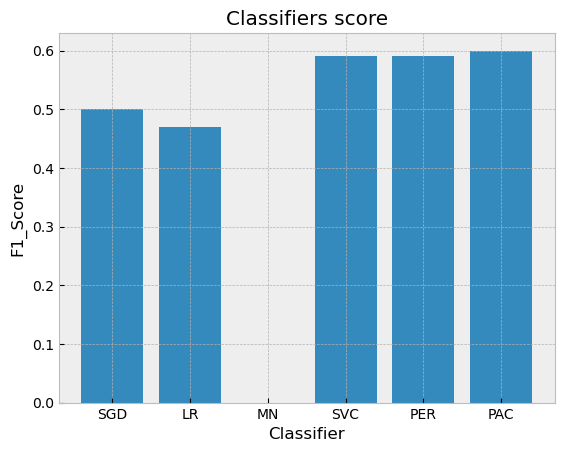

In [148]:
import matplotlib.pyplot as plt

# Create lists of keys and values

keys=['SGD','LR','MN','SVC','PER','PAC']
values = list(Scores.values())
values=[float(i) for i in values]

# Create a bar graph
plt.bar(keys, values)

# Add labels and title
plt.xlabel('Classifier')
plt.ylabel('F1_Score')
plt.title('Classifiers score')

# Show the plot
plt.show()